In [1]:
import xlrd
book = xlrd.open_workbook("data/Table S2 - Positional variability and color of all neurons in males and hermaphrodites v2.xlsx")

print("Worksheet names: {0}".format(book.sheet_names()))

data = {'Hermaphrodite Head':{}, 'Hermaphrodite Tail':{},'Male Head':{}, 'Male Tail':{}}

for ws in range(book.nsheets):
    sheet_name = book.sheet_names()[ws]
    
    print('Parsing sheet: %s'%sheet_name)
    sh = book.sheet_by_index(ws)
    
    for rx in range(sh.nrows):
            
        neuron = sh.row(rx)[0].value
        if rx>1 and rx<192:#and neuron.startswith('V'):
            ref = '%s %s'%(sheet_name.split()[0],sheet_name.split()[1])
            if 'Positions' in sheet_name:
                data[ref][neuron]={}
                data[ref][neuron]['volume'] = sh.row(rx)[1].value
                data[ref][neuron]['ap_position'] = sh.row(rx)[2].value
                data[ref][neuron]['dv_position'] = sh.row(rx)[3].value
                data[ref][neuron]['lr_position'] = sh.row(rx)[4].value
                #'A-P Distance (μm)	D-V Distance (μm)	L-R Distance (μm)	A-P Variance (μm2)	D-V Variance (μm2)	L-R Variance (μm2)	Effect Size (D
            if 'Colors' in sheet_name:
                if neuron in data[ref]:
                    data[ref][neuron]['mNeptune2.5'] = sh.row(rx)[1].value
                    data[ref][neuron]['CyOFP1'] = sh.row(rx)[2].value
                    data[ref][neuron]['mTagBFP2'] = sh.row(rx)[3].value
                
import pprint
pp = pprint.PrettyPrinter(indent=4)

#pp.pprint(data)
            

Worksheet names: ['Hermaphrodite Head Positions', 'Hermaphrodite Head Colors', 'Hermaphrodite Tail Positions', 'Hermaphrodite Tail Colors', 'Male Head Positions', 'Male Head Colors', 'Male Tail Positions', 'Male Tail Colors']
Parsing sheet: Hermaphrodite Head Positions
Parsing sheet: Hermaphrodite Head Colors
Parsing sheet: Hermaphrodite Tail Positions
Parsing sheet: Hermaphrodite Tail Colors
Parsing sheet: Male Head Positions
Parsing sheet: Male Head Colors
Parsing sheet: Male Tail Positions
Parsing sheet: Male Tail Colors


In [2]:

def translate_pal_color(mneptune,cyofp1, mtag):
    # Very, very, very approximately!
    mx = max([mneptune,cyofp1, mtag])
    rgb = (mneptune/mx,cyofp1/mx, mtag/mx)
    #print('Converted expression (%.3f,%.3f,%.3f) to %s'%(mneptune,cyofp1, mtag,rgb))
    return rgb


for ref in data:
     
    for neuron in data[ref]:
        #print('Handling neuron %s'%neuron)
        if neuron in data[ref]:
            try:
                color = translate_pal_color(data[ref][neuron]['mNeptune2.5'],
                                            data[ref][neuron]['CyOFP1'],
                                            data[ref][neuron]['mTagBFP2'])
            except Exception as e:
                print('Exception getting color for %s'%(neuron,e))
                color= (0,0,0)

            data[ref][neuron]['color'] = color
            label = '%s %s'%(neuron, [float('%.2f'%f) for f in color])
            data[ref][neuron]['label'] = label
            #print(label)
        

'mNeptune2.5'
'mNeptune2.5'


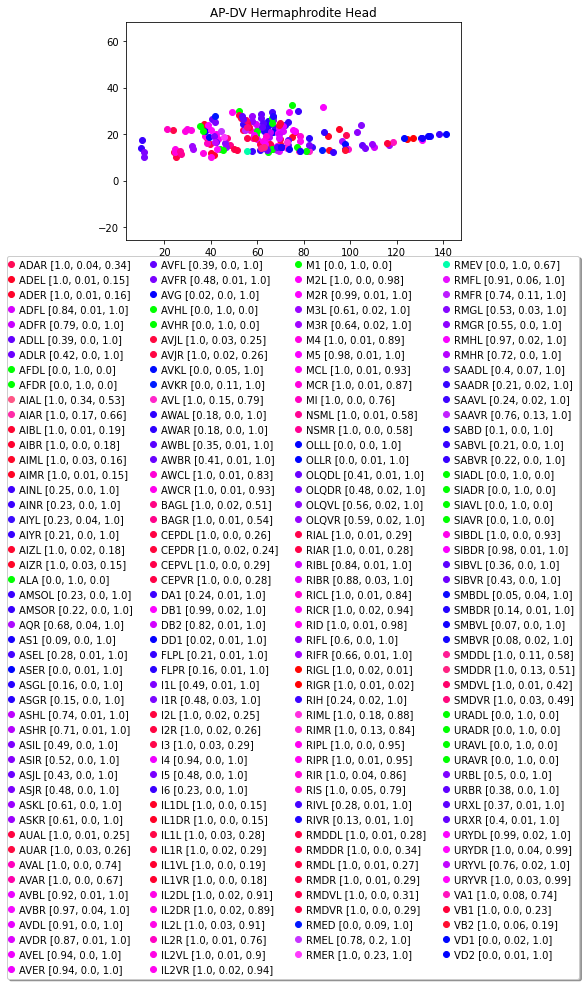

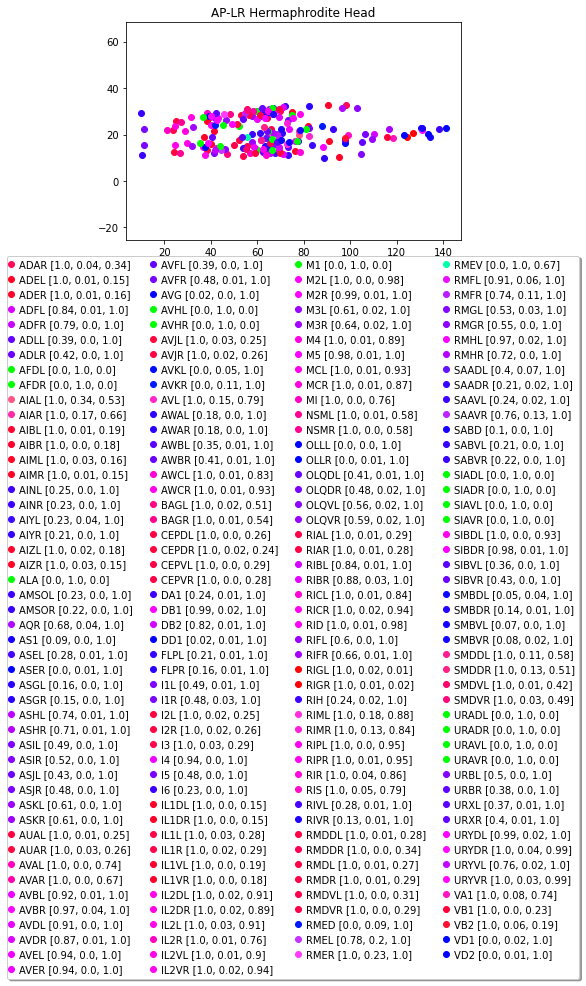

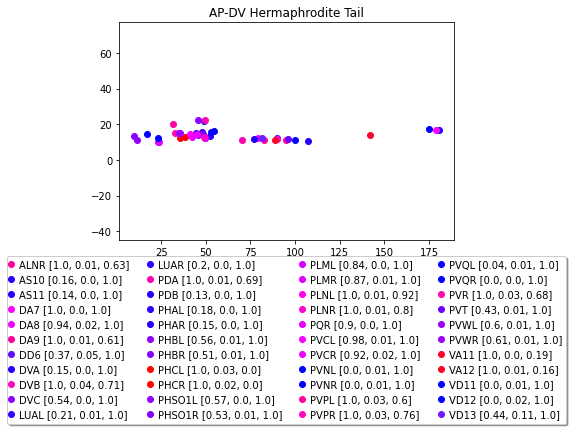

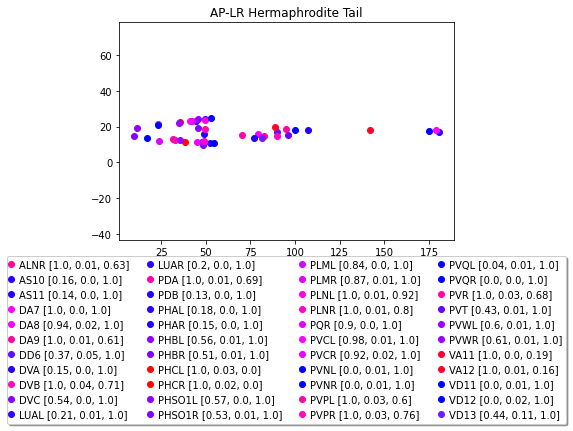

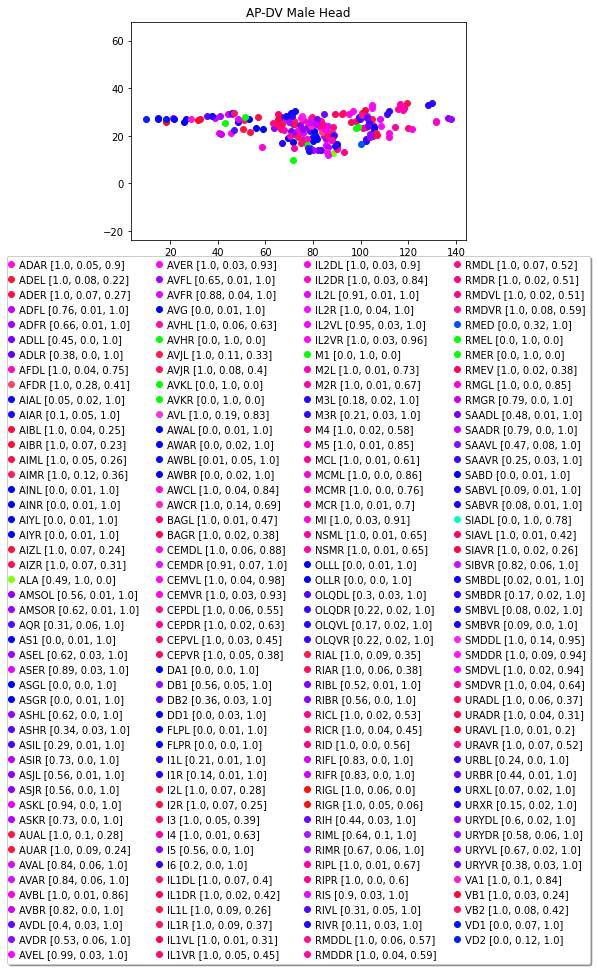

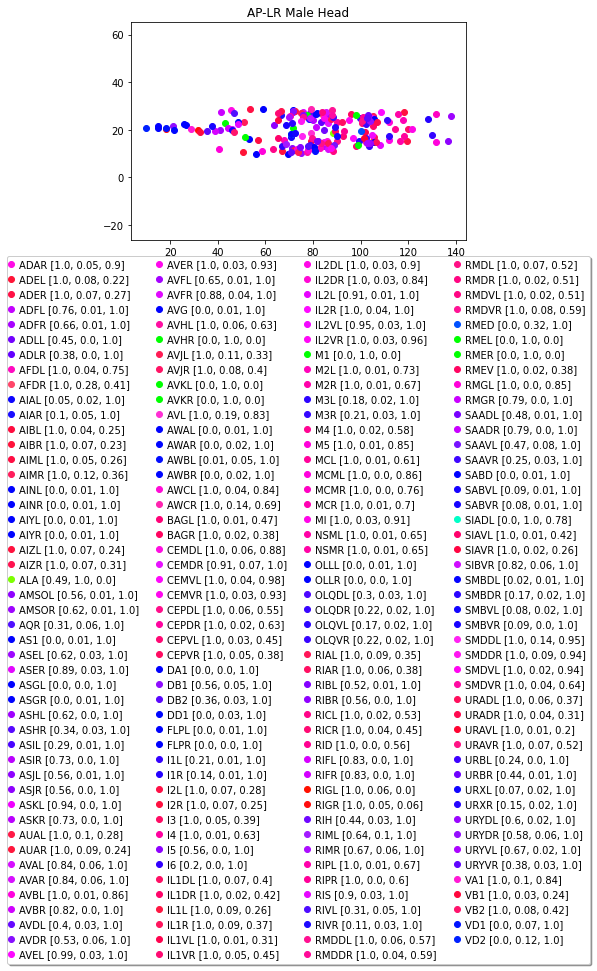

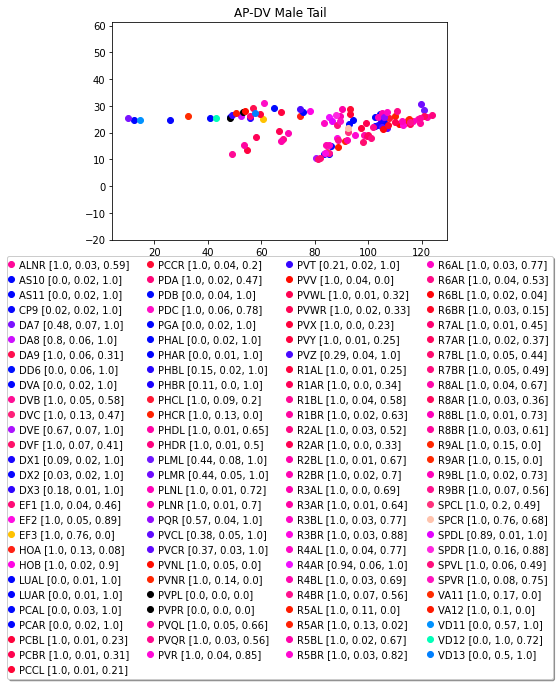

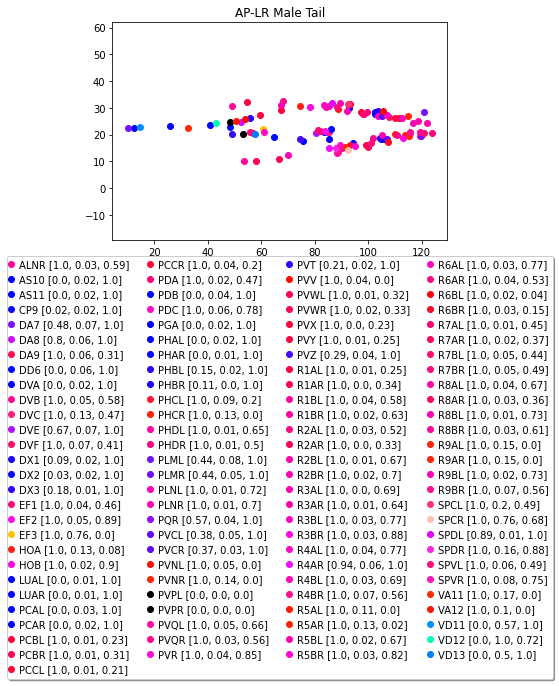

In [3]:
import matplotlib
import matplotlib.pyplot as plt


for ref in data:
    plt.figure()
    plt.title('AP-DV %s'%ref)
    plt.axis('equal')
    
    matplotlib.rcParams['legend.handlelength'] = 0
    for neuron in data[ref]:
        
        label=data[ref][neuron]['label']# if neuron.startswith('V') else None
        plt.plot(data[ref][neuron]['ap_position'], 
                 data[ref][neuron]['dv_position'], 
                 marker="o",
                 linestyle=None,
                 color=data[ref][neuron]['color'],
                 label=label)

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)

    plt.figure()
    plt.title('AP-LR %s'%ref)
    plt.axis('equal')
    for neuron in data[ref]:

        plt.plot([data[ref][neuron]['ap_position']], 
                 [data[ref][neuron]['lr_position']], 
                 marker="o",
                 linestyle=None,
                 color=data[ref][neuron]['color'],
                 label=data[ref][neuron]['label'])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)

plt.show()

In [16]:
import neuroml

import neuroml.writers as writers


sets_to_include = ['Hermaphrodite Head']

prototype_neuron = 'GenericNeuronCell'
cell = neuroml.FitzHughNagumoCell(id=prototype_neuron, I=0.1)


for ref in data:
    if ref in sets_to_include:
        
        nml_doc = neuroml.NeuroMLDocument(id="NeuroPAL_%s"%ref.replace(' ','_'))
        nml_doc.fitz_hugh_nagumo_cells.append(cell)

        net = neuroml.Network(id=nml_doc.id)
        nml_doc.networks.append(net)
    
        for neuron in data[ref]:


            pop = neuroml.Population(id="%s"%neuron, component=prototype_neuron, type="populationList")
            net.populations.append(pop)
            c = data[ref][neuron]['color']
            pop.properties.append(neuroml.Property(tag="color", value='%f %f %f'%(c[0],c[1],c[2])))
            pop.properties.append(neuroml.Property(tag="radius", value=2))

            inst = neuroml.Instance(id="0")
            pop.instances.append(inst)

            inst.location = neuroml.Location(x=data[ref][neuron]['ap_position'], 
                                     y=data[ref][neuron]['dv_position'], 
                                     z=data[ref][neuron]['lr_position'])

        nml_file = 'NeuroML2/%s.net.nml'%net.id
        
        writers.NeuroMLWriter.write(nml_doc, nml_file)

        print("Written network file to: "+nml_file)


        ###### Validate the NeuroML ######    

        from neuroml.utils import validate_neuroml2

        validate_neuroml2(nml_file)
            

Written network file to: NeuroML2/NeuroPAL_Hermaphrodite_Head.net.nml
Validating NeuroML2/NeuroPAL_Hermaphrodite_Head.net.nml against /Users/padraig/anaconda/envs/py37/lib/python3.7/site-packages/libNeuroML-0.2.57-py3.7.egg/neuroml/nml/NeuroML_v2.2.xsd
It's valid!
